In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tensorflow.keras.models import load_model


In [2]:
def normalize(train, test):
    trn_mean = train.mean(axis=(0,1,2))
    trn_std = train.std(axis=(0,1,2))
    print(f'train_mean : {trn_mean}')
    print(f'train_std : {trn_std}')
    
    train = (train - trn_mean) / trn_std
    test = (test - trn_mean) / trn_std
    return train, test

In [3]:
train_files = os.listdir('../data/train')

train = []
for file in train_files:
    try:
        data = np.load('../data/train/'+file).astype('float32')
        train.append(data)
    except:
        continue

In [4]:
submission = pd.read_csv('../data/sample_submission.csv')

In [5]:
test = []
for sub_id in submission['id']:
    data = np.load('../data/test/'+'subset_'+sub_id+'.npy').astype('float32')
    test.append(data)

In [6]:
train = np.array(train)
test = np.array(test)

x_train = train[:,:,:,:10]
y_train = train[:,:,:,14]
test = test[:,:,:,:10]

In [7]:
x_train.shape, y_train.shape

((76345, 40, 40, 10), (76345, 40, 40))

In [8]:
y_train_ = y_train.reshape(-1,y_train.shape[1]*y_train.shape[2])

x_train = np.delete(x_train, np.where(y_train_<0)[0], axis=0)
y_train = np.delete(y_train, np.where(y_train_<0)[0], axis=0)
y_train = y_train.reshape(-1, x_train.shape[1], x_train.shape[2],1)
# y_test = y_test.reshape(-1, y_test.shape[1], y_test.shape[2],1)

y_train_ = np.delete(y_train_, np.where(y_train_<0)[0], axis=0)

x_train.shape, y_train.shape

((75957, 40, 40, 10), (75957, 40, 40, 1))

In [9]:
x_train, test = normalize(x_train, test)

train_mean : [70.69205  70.69761  70.680916 70.6809   70.6809   70.6809   70.6809
 70.6809   70.6809   20.302282]
train_std : [95.17079  95.16772  95.116905 95.11655  95.11654  95.116585 95.11658
 95.11654  95.11655  48.27234 ]


In [10]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.025, random_state=7777)
# y_train = np.expand_dims(y_train, axis=-1)
# y_test = np.expand_dims(y_test, axis=-1)

In [11]:
def mae_over_fscore(y_true, y_pred):
    '''
    y_true: sample_submission.csv 형태의 실제 값
    y_pred: sample_submission.csv 형태의 예측 값
    '''

    y_true = np.array(y_true)
    y_true = y_true.reshape(1, -1)[0]  
    
    y_pred = np.array(y_pred)
    y_pred = y_pred.reshape(1, -1)[0]
    
    # 실제값이 0.1 이상인 픽셀의 위치 확인
    IsGreaterThanEqualTo_PointOne = y_true >= 0.1
    
    # 실제 값에 결측값이 없는 픽셀의 위치 확인 
    IsNotMissing = y_true >= 0
    
    # mae 계산
    mae = np.mean(np.abs(y_true[IsGreaterThanEqualTo_PointOne] - y_pred[IsGreaterThanEqualTo_PointOne]))
    
    # f1_score 계산 위해, 실제값에 결측값이 없는 픽셀에 대해 1과 0으로 값 변환
    y_true = np.where(y_true[IsNotMissing] >= 0.1, 1, 0)
    
    y_pred = np.where(y_pred[IsNotMissing] >= 0.1, 1, 0)
    
    # f1_score 계산    
    f_score = f1_score(y_true, y_pred) 
    # f1_score가 0일 나올 경우를 대비하여 소량의 값 (1e-07) 추가 
    return mae / (f_score + 1e-07) 

def mae(y_true, y_pred):    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    over_threshold = y_true >= 0.1
    
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    remove_NAs = y_true >= 0
    
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def score(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float16,  name='custom_mse') 
    return score

In [12]:
import tensorflow as tf
from tensorflow.keras import losses

def bce_dice_loss(y_true, y_pred):
    mae_loss = losses.mean_absolute_error(y_true, y_pred)
    y_true, y_pred = tf.math.sigmoid(y_true), tf.math.sigmoid(y_pred)
    
    return losses.kullback_leibler_divergence(y_true, y_pred) + mae_loss # + dice_loss(y_true, y_pred)

In [13]:
def H_flip(data):
    return np.flip(data, axis=1)
def V_flip(data):
    return np.flip(data, axis=2)

In [14]:
del x_train
del y_train

In [15]:
x_test.shape

(1899, 40, 40, 10)

In [50]:
def proba2tf(proba, percen):
#     proba = proba.flatten()
    return proba >= np.percentile(proba, percen)

In [76]:
pred_list = list()

clf_model = load_model('../models/th_model.h5', compile=False)
# clf_model = load_model('../models/di_th_model.h5', compile=False)

clf_proba = clf_model.predict(x_test)

In [77]:
score_list = list()

for i in range(85, 100):
    score_list.append(fscore(y_test, proba2tf(clf_proba, i)))

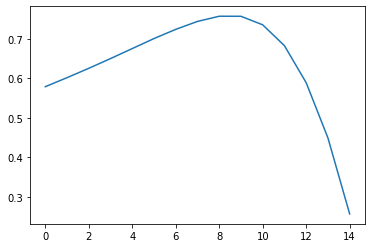

In [78]:
plt.plot(score_list)

In [82]:
fscore(y_test, proba2tf(clf_proba, 93))

0.7577804295942722

In [ ]:
clf_model = load_model('../models/th_model.h5', compile=False)
percen = 93
pred_list = list()
for i in range(5):
    model = load_model('../models/dn_model'+str(i)+'.h5', compile=False)
    
    pred = model.predict(test) / 4
    pred += H_flip(model.predict(H_flip(test))) / 4
    pred += V_flip(model.predict(V_flip(test))) / 4
    pred += H_flip(V_flip(model.predict(H_flip(V_flip(test))))) / 4
    
    clf_proba = clf_model.predict(test)
    clf_pred = proba2tf(clf_proba, precen)
    
    pred_list.append(pred)

In [90]:
clf_model = load_model('../models/th_model.h5', compile=False)
percen = 93
pred_list = list()
for i in range(5):
    model = load_model('../models/dn_model'+str(i)+'.h5', compile=False)
    
    pred = model.predict(x_test)  / 4
    pred += H_flip(model.predict(H_flip(x_test)))  / 4
    pred += V_flip(model.predict(V_flip(x_test)))  / 4
    pred += H_flip(V_flip(model.predict(H_flip(V_flip(x_test))))) / 4
    
    pred *= proba2tf(clf_model.predict(x_test), percen)
    pred_list.append(pred)
    score = mae_over_fscore(y_test, pred)
    print(score)

1.4918293632560988
1.4910185055495533
1.4868968521159427
1.4871816589166553
1.4934111950619569


In [116]:
import seaborn as sns

color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()

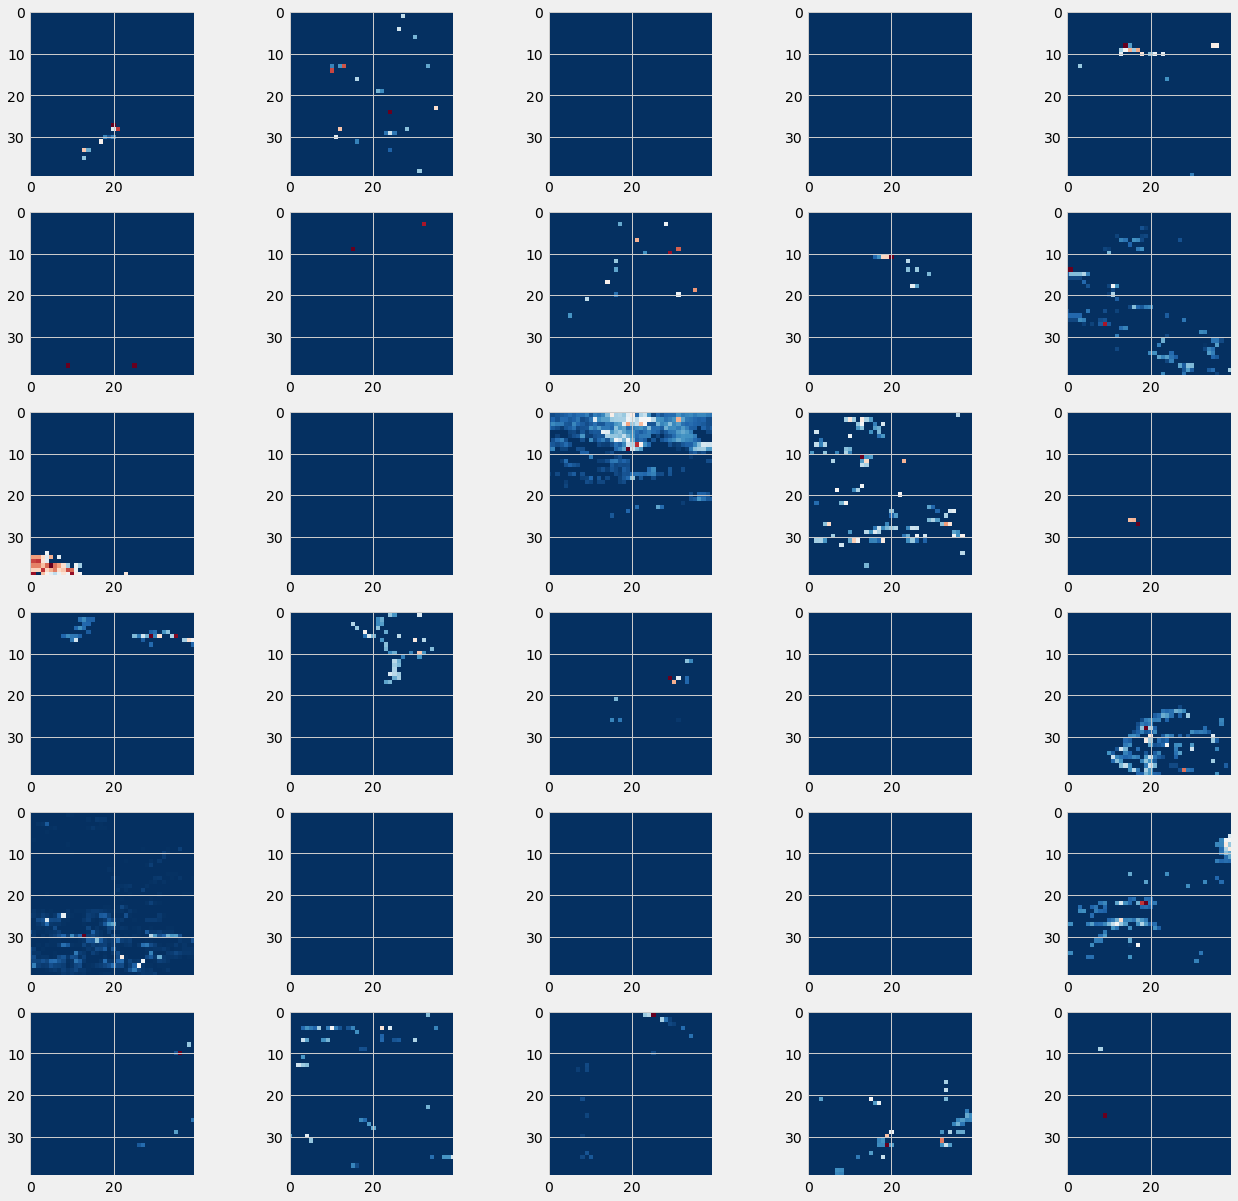

In [125]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20, 20))

for i in range(30):
    plt.subplot(6,5,i+1)
    plt.imshow(y_test[i,:,:,-1], cmap = color_map)

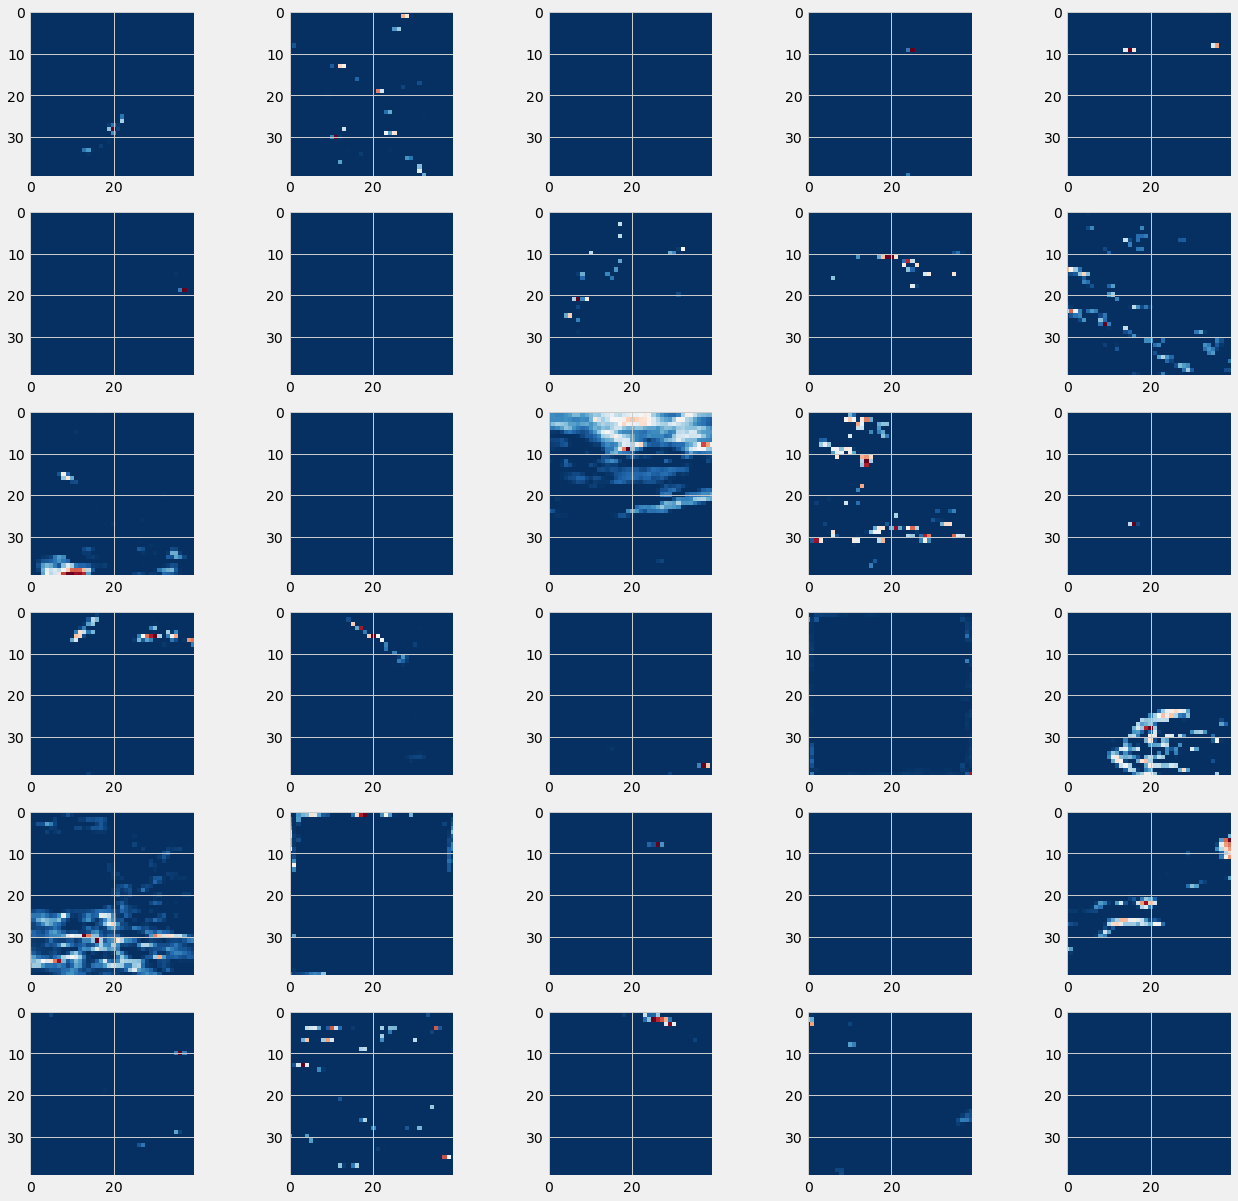

In [124]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20, 20))

for i in range(30):
    plt.subplot(6,5,i+1)
    plt.imshow(mean_pred[i,:,:,-1], cmap = color_map)

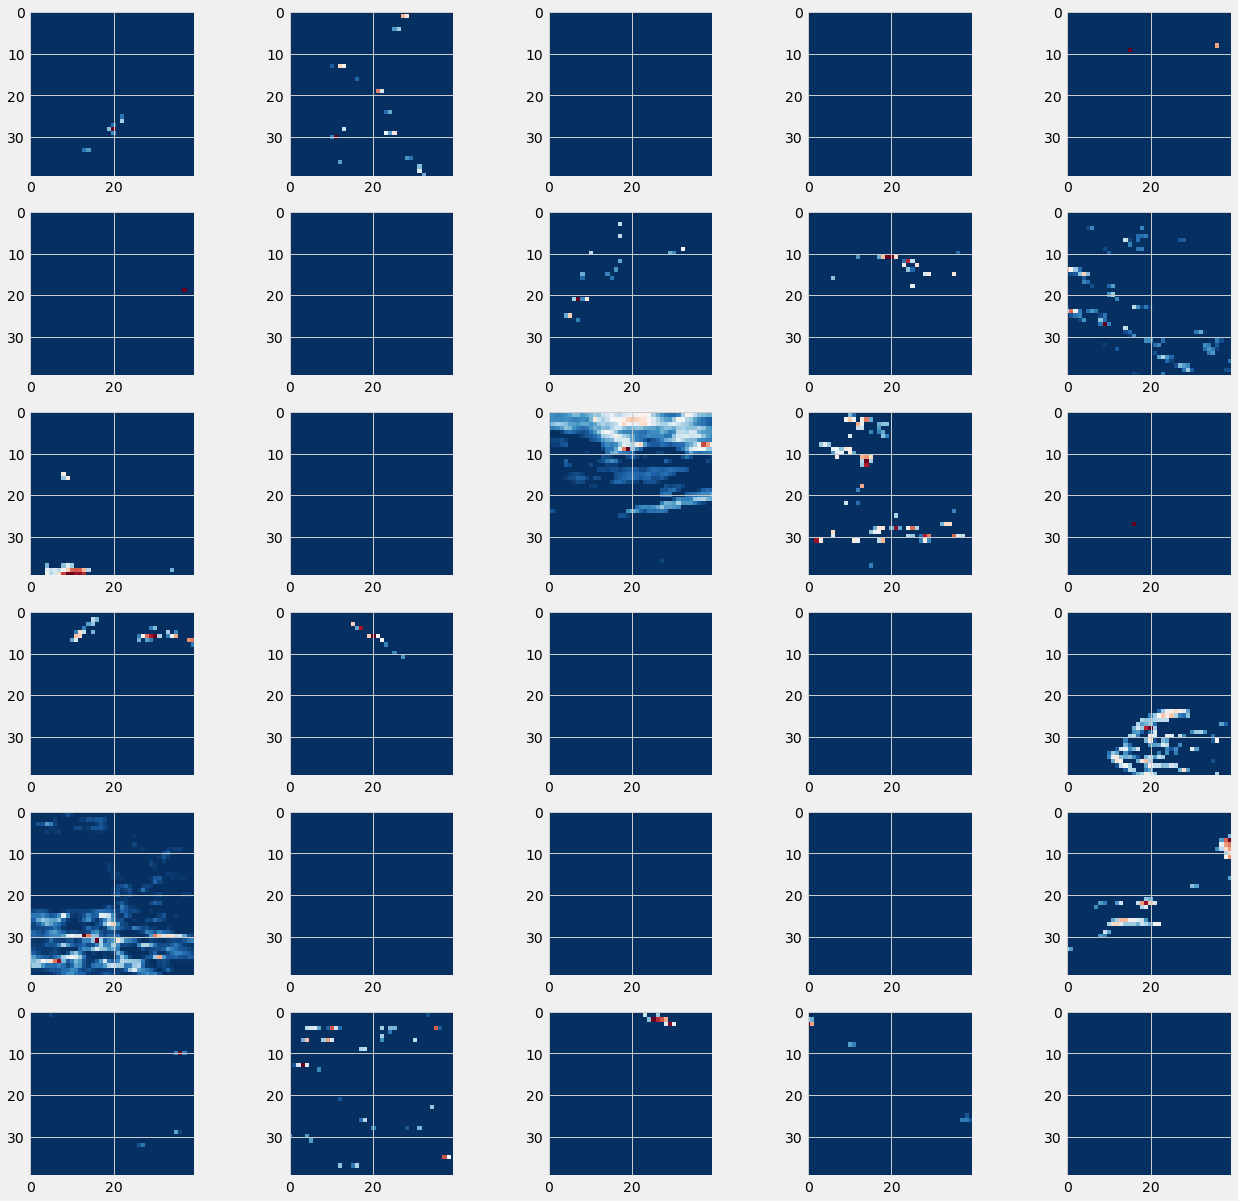

In [126]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20, 20))

for i in range(30):
    plt.subplot(6,5,i+1)
    plt.imshow(np.where(mean_pred>=0.13, mean_pred, 0.000001)[i,:,:,-1], cmap = color_map)

In [25]:
y_test.shape

(1899, 40, 40, 1)

In [38]:
score_list = list()
for i in np.arange(0.1, 0.15, 0.001):
    score_list.append(fscore(y_test, np.where(mean_pred>=i, mean_pred, 0.09999999)))

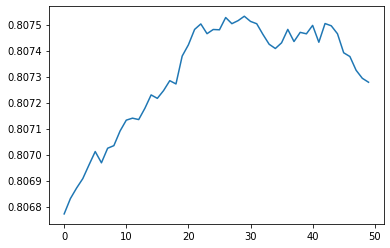

In [39]:
import matplotlib.pyplot as plt
plt.plot(score_list)

In [63]:
post_pred = np.where(mean_pred>=0.13, mean_pred, 0.09999999)

In [66]:
post_pred[(pred_arr[0] == 0) | (pred_arr[1] == 0)  | (pred_arr[2] == 0)  | (pred_arr[3] == 0)  | (pred_arr[4] == 0)] = 0

In [67]:
mae_over_fscore(y_test, post_pred)

1.3895567622119624

In [68]:
mae_over_fscore(y_test, np.where(mean_pred>=0.13, mean_pred, 0.09999999))

1.3688199476443557

In [47]:
mae_over_fscore(y_test, np.where(mean_pred>=0.13, mean_pred, 0.000001))

1.392260492211644

In [21]:
mae_over_fscore(y_test, np.where((mean_pred>=.000001), mean_pred, mean_pred+.099999))

1.3756521590379411

In [52]:

# 0.000001 ~ 0.00001
mae_over_fscore(y_test, np.where((mean_pred >= 0.00001), mean_pred , mean_pred + (0.1 - 0.00001)))
# np.where((mean_pred >= 0.000001) & (mean_pred <= 0.00001), mean_pred + 0.0999999, mean_pred)

1.375546101958612

In [57]:
np.where((mean_pred>=.000001), mean_pred, mean_pred+.099999).shape

(1899, 40, 40, 1)

In [41]:
pred_list = list()
for i in range(5):
    model = load_model('../models/dn_model'+str(i)+'.h5', compile=False)
    pred = model.predict(test) / 4
    pred += H_flip(model.predict(H_flip(test))) / 4
    pred += V_flip(model.predict(V_flip(test))) / 4
    pred += H_flip(V_flip(model.predict(H_flip(V_flip(test))))) / 4
    
    pred_list.append(pred)

In [42]:
test_pred = np.array(pred_list).mean(axis=0)

In [43]:
submission.iloc[:,1:] = np.where(test_pred>=0.13, test_pred, 0.09999999).reshape(-1,1600)

In [44]:
submission.to_csv('../dn_tta_fold_submission.csv', index=False)

In [45]:
submission

,id,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,...,px_1591,px_1592,px_1593,px_1594,px_1595,px_1596,px_1597,px_1598,px_1599,px_1600
0,029858_01,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.1,0.1,...,0.100000,0.10000,0.10000,0.10000,0.100000,0.100000,0.100000,0.100000,0.100000,0.10000
1,029858_02,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.1,0.1,...,0.100000,0.10000,0.10000,0.10000,0.100000,0.100000,0.100000,0.100000,0.100000,0.10000
2,029858_03,0.100000,0.100000,0.100000,0.392387,0.446254,0.100000,0.100000,0.1,0.1,...,0.100000,0.10000,0.10000,0.10000,0.100000,0.100000,0.100000,0.100000,0.100000,0.10000
3,029858_05,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.1,0.1,...,0.100000,0.10000,0.10000,0.10000,0.100000,0.100000,0.100000,0.100000,0.100000,0.10000
4,029858_07,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.1,0.1,...,2.136517,2.80318,1.81593,1.01149,0.945962,2.050541,4.422707,3.825837,2.560762,1.71537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2411,031287_08,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.1,0.1,...,0.100000,0.10000,0.10000,0.10000,0.100000,0.100000,0.100000,0.100000,0.100000,0.10000
2412,031288_01,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.1,0.1,...,0.100000,0.10000,0.10000,0.10000,0.100000,0.100000,0.100000,0.100000,0.100000,0.10000
2413,031288_02,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.1,0.1,...,0.100000,0.10000,0.10000,0.10000,0.100000,0.100000,0.100000,0.240252,0.100000,0.10000
2414,031288_08,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.1,0.1,...,0.100000,0.10000,0.10000,0.10000,0.100000,0.100000,0.100000,0.100000,0.100000,0.10000


In [16]:
pred_list = list()
for i in range(5):
    model = load_model('../models/model'+str(i)+'.h5', compile=False)
    pred = model.predict(x_test)
    pred_list.append(pred)
    print(mae_over_fscore(y_test, pred))

1.4664602168113352
1.4610965198217116
1.4626504458004295
1.4562686204254747
1.4595210668301946


In [20]:
pred_arr = np.array(pred_list)

## Mean Ensemble

In [23]:
mae_over_fscore(y_test, pred_arr.mean(axis=0))

1.4396796084883108

## Max Ensemble

In [24]:
mae_over_fscore(y_test, pred_arr.max(axis=0))

1.4778438444058104

## Min Ensemble

In [35]:
mae_over_fscore(y_test, pred_arr.min(axis=0))

1.4878294905182612

## Power Ensemble

In [36]:
mae_over_fscore(y_test, (pred_arr**3).mean(axis=0)**(1/3))

1.4453927152920256

In [37]:
mae_over_fscore(y_test, (pred_arr**2).mean(axis=0)**(1/2))

1.4430711487413366

In [48]:
for i in range(1):
    model = load_model('../models/dn_model'+str(i)+'.h5', compile=False)
    pred = model.predict(x_test)
    print(mae_over_fscore(y_test, pred))

1.4174659815347188


In [30]:
for i in range(1):
    model = load_model('../models/dn_model'+str(i)+'.h5', compile=False)
    pred = model.predict(x_test)
    print(mae_over_fscore(y_test, pred))

1.4208619383467487


In [49]:
model = load_model('../models/dn_model'+str(0)+'.h5', compile=False)
test_pred = model.predict(test)

In [50]:
submission.iloc[:,1:] = test_pred.reshape(-1,1600)

In [52]:
submission.to_csv('../dn_fold_0_submission.csv', index=False)

In [16]:
model = load_model('../models/ep6_model'+str(0)+'.h5', compile=False)
test_pred = model.predict(test)

In [18]:
test_pred.shape

(2416, 40, 40, 1)

In [19]:
submission.iloc[:,1:] = test_pred.reshape(-1,1600)

In [21]:
submission.to_csv('../fold_0_submission.csv', index=False)

In [15]:
for i in range(1):
    model = load_model('../models/n3_model'+str(i)+'.h5', compile=False)
    pred = model.predict(x_test)
    print(mae_over_fscore(y_test, pred))

1.4195365492581529


In [14]:
for i in range(2):
    model = load_model('../models/n_v2_model'+str(i)+'.h5', compile=False)
    pred = model.predict(x_test)
    print(mae_over_fscore(y_test, pred))

1.4037408257759385
1.4237159766327023


In [16]:
test_pred_list = list()
for i in range(3):
    model = load_model('../models/n_model'+str(i)+'.h5', compile=False)
    test_pred = model.predict(test) / 4
    test_pred += H_flip(model.predict(H_flip(test))) / 4
    test_pred += V_flip(model.predict(V_flip(test))) / 4
    test_pred += H_flip(V_flip(model.predict(H_flip(V_flip(test))))) / 4
    
    test_pred_list.append(test_pred)
    
#     submission.iloc[:,1:] = test_pred.reshape(-1,1600)

In [22]:
submission.iloc[:,1:] = np.array(test_pred_list).mean(axis=0).reshape(-1,1600)

In [24]:
submission.to_csv('../tta_n_fold3_submission.csv', index=False)

In [15]:
for i in range(1):
    model = load_model('../models/n_v3_model'+str(i)+'.h5', compile=False)
    pred = model.predict(x_test)

In [16]:
print(mae_over_fscore(y_test, pred))

1.403063247263854


In [14]:
for i in range(1):
    model = load_model('../models/n_model'+str(i)+'.h5', compile=False)
    pred = model.predict(x_test)

In [15]:
print(mae_over_fscore(y_test, pred))

1.4209845102886833


In [14]:
for i in range(1):
    model = load_model('../models/n_v2_model'+str(i)+'.h5', compile=False)
    pred = model.predict(x_test)

In [15]:
print(mae_over_fscore(y_test, pred))

1.4037408257759385


In [16]:
for i in range(1):
    model = load_model('../models/n_v2_model'+str(i)+'.h5', compile=False)
    test_pred = model.predict(test) / 4
    test_pred += H_flip(model.predict(H_flip(test))) / 4
    test_pred += V_flip(model.predict(V_flip(test))) / 4
    test_pred += H_flip(V_flip(model.predict(H_flip(V_flip(test))))) / 4
    
#     submission.iloc[:,1:] = test_pred.reshape(-1,1600)

In [17]:
submission.iloc[:,1:] = test_pred.reshape(-1,1600)

In [18]:
submission.to_csv('../tta_nv2_submission.csv', index=False)

In [13]:
for i in range(1):
    model = load_model('../models/ep2_model'+str(i)+'.h5', compile=False)
    pred = model.predict(x_test)

In [14]:
print(mae_over_fscore(y_test, pred))

1.4300765435286529


In [81]:
for i in range(1):
    model = load_model('../models/ep_model'+str(i)+'.h5', compile=False)
    test_pred = model.predict(test) / 4
    test_pred += H_flip(model.predict(H_flip(test))) / 4
    test_pred += V_flip(model.predict(V_flip(test))) / 4
    test_pred += H_flip(V_flip(model.predict(H_flip(V_flip(test))))) / 4
    
#     submission.iloc[:,1:] = test_pred.reshape(-1,1600)

In [15]:
for i in range(1):
    model = load_model('../models/ep3_model'+str(i)+'.h5', compile=False)
    pred = model.predict(x_test)

In [16]:
print(mae_over_fscore(y_test, pred))

1.4105211408005425


In [18]:
for i in range(1):
    model = load_model('../models/ep3_model'+str(i)+'.h5', compile=False)
    test_pred = model.predict(test) / 4
    test_pred += H_flip(model.predict(H_flip(test))) / 4
    test_pred += V_flip(model.predict(V_flip(test))) / 4
    test_pred += H_flip(V_flip(model.predict(H_flip(V_flip(test))))) / 4
    
#     submission.iloc[:,1:] = test_pred.reshape(-1,1600)

In [20]:
submission.iloc[:,1:] = test_pred.reshape(-1,1600)

In [21]:
submission.to_csv('../tta_e150_submission.csv', index=False)

In [13]:
for i in range(1):
    model = load_model('../models/ep4_model'+str(i)+'.h5', compile=False)
    pred = model.predict(x_test)

In [14]:
print(mae_over_fscore(y_test, pred))

1.4071259631821091


In [17]:
for i in range(1):
    model = load_model('../models/ep4_model'+str(i)+'.h5', compile=False)
    test_pred = model.predict(test) / 4
    test_pred += H_flip(model.predict(H_flip(test))) / 4
    test_pred += V_flip(model.predict(V_flip(test))) / 4
    test_pred += H_flip(V_flip(model.predict(H_flip(V_flip(test))))) / 4

In [18]:
submission.iloc[:,1:] = test_pred.reshape(-1,1600)

In [19]:
submission.to_csv('../tta_v4_submission.csv', index=False)

In [14]:
for i in range(1):
    model = load_model('../models/ep5_model'+str(i)+'.h5', compile=False)
    pred = model.predict(x_test)

In [15]:
print(mae_over_fscore(y_test, pred))

1.4070801773313917


In [16]:
for i in range(1):
    model = load_model('../models/ep5_model'+str(i)+'.h5', compile=False)
    test_pred = model.predict(test) / 4
    test_pred += H_flip(model.predict(H_flip(test))) / 4
    test_pred += V_flip(model.predict(V_flip(test))) / 4
    test_pred += H_flip(V_flip(model.predict(H_flip(V_flip(test))))) / 4

In [17]:
submission.iloc[:,1:] = test_pred.reshape(-1,1600)

In [18]:
submission.to_csv('../tta_v5_submission.csv', index=False)

In [14]:
for i in range(1):
    model = load_model('../models/ep6_model'+str(i)+'.h5', compile=False)
    pred = model.predict(x_test)

In [15]:
print(mae_over_fscore(y_test, pred))

1.407871707819842


In [ ]:
for i in range(1):
    model = load_model('../models/ep6_model'+str(i)+'.h5', compile=False)
    test_pred = model.predict(test) / 4
    test_pred += H_flip(model.predict(H_flip(test))) / 4
    test_pred += V_flip(model.predict(V_flip(test))) / 4
    test_pred += H_flip(V_flip(model.predict(H_flip(V_flip(test))))) / 4

In [ ]:
submission.iloc[:,1:] = test_pred.reshape(-1,1600)

In [ ]:
submission.to_csv('../tta_v6_submission.csv', index=False)

In [80]:
for i in range(1):
    model = load_model('../models/ep_model'+str(i)+'.h5', compile=False)
    pred = model.predict(test)
#     pred += H_flip(model.predict(H_flip(test))) / 4
#     pred += V_flip(model.predict(V_flip(test))) / 4
#     pred += H_flip(V_flip(model.predict(H_flip(V_flip(test))))) / 4


In [94]:
submission.iloc[:,1:] = test_pred.reshape(-1,1600)


In [95]:
submission.to_csv('../tta_e70_submission.csv', index=False)

In [90]:
2416 * 40 * 40

3865600

In [85]:
(test_pred == pred).sum()

3457431

In [78]:
submission

,id,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,...,px_1591,px_1592,px_1593,px_1594,px_1595,px_1596,px_1597,px_1598,px_1599,px_1600
0,029858_01,0.083131,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,029858_02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,029858_03,0.000000,0.000000,0.000000,0.241170,0.199682,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,029858_05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,029858_07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,2.319063,3.006228,1.77588,0.931082,0.890393,1.838529,3.758155,3.495357,2.494151,1.705509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2411,031287_08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2412,031288_01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2413,031288_02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.115239,0.313061,0.000000,0.000000
2414,031288_08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [76]:
submission

,id,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,...,px_1591,px_1592,px_1593,px_1594,px_1595,px_1596,px_1597,px_1598,px_1599,px_1600
0,029858_01,0.166262,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,029858_02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,029858_03,0.000000,0.000000,0.000000,1.082412,0.767777,0.000000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,029858_05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,029858_07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,...,6.970048,8.984761,5.400959,2.679385,2.789159,5.642002,11.462145,10.615288,7.537982,5.133691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2411,031287_08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2412,031288_01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2413,031288_02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.281996,0.886496,0.000000,0.000000
2414,031288_08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [79]:
submission.to_csv('../tta_e70_submission.csv', index=False)

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

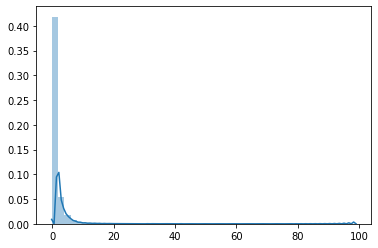

In [36]:
sns.distplot(np.delete(pred.flatten(), np.where(pred.flatten() == 0.)))

In [54]:
def trans_th(pred, th):
    return np.where(pred > th, pred, 0.)

In [53]:
print(mae_over_fscore(y_test, pred))

1.435968253748673


In [62]:
th_list = list()
score_list = list()
for th in np.arange(0, 0.01, 0.001):
    score_list.append(mae_over_fscore(y_test, trans_th(pred, th)))
    th_list.append(th)

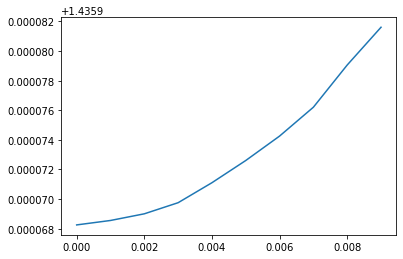

In [63]:
plt.plot(th_list, score_list)

In [15]:
model = load_model('../models/f9_model'+str(0)+'.h5', compile=False)
test_pred = model.predict(test)
submission.iloc[:,1:] += test_pred.reshape(-1,1600)

In [16]:
submission.head()

,id,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,...,px_1591,px_1592,px_1593,px_1594,px_1595,px_1596,px_1597,px_1598,px_1599,px_1600
0,029858_01,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,029858_02,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,029858_03,0.0,0.0,0.0,0.500479,0.245724,0.0,0.0,0.0,0.0,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,029858_05,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,029858_07,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,1.6241,1.894137,1.469664,0.783405,0.877226,1.624811,4.236577,3.401494,2.070728,1.532017


In [17]:
submission.to_csv('../f9_ens_submission.csv', index=False)

# TTA validation score

## Normal pred

In [13]:
for i in range(5):
    model = load_model('../models/model'+str(i)+'.h5', compile=False)
    pred = model.predict(x_test)
    print(mae_over_fscore(y_test, pred))


1.4652597373694614


## H flip pred

In [15]:
for i in range(5):
    model = load_model('../models/model'+str(i)+'.h5', compile=False)
    pred = model.predict(H_flip(x_test))
    print(mae_over_fscore(y_test, H_flip(pred)))


1.4648504059601355
1.4610107577431999
1.4636915652736628
1.4562302679895618
1.4605862247250088


## V flip pred

In [16]:
for i in range(5):
    model = load_model('../models/model'+str(i)+'.h5', compile=False)
    pred = model.predict(V_flip(x_test))
    print(mae_over_fscore(y_test, V_flip(pred)))


1.4644163558779544
1.4608826551295973
1.4641007758599311
1.4554215610903776
1.4609663894147449


## H & V pred

In [17]:
for i in range(5):
    model = load_model('../models/model'+str(i)+'.h5', compile=False)
    pred = model.predict(H_flip(V_flip(x_test)))
    print(mae_over_fscore(y_test, H_flip(V_flip(pred))))


1.4616363023476697
1.4583810500970515
1.4648306247006126
1.4533627671940217
1.4626030782097923


## TTA

In [14]:
for i in range(5):
    model = load_model('../models/model'+str(i)+'.h5', compile=False)
    test_pred = model.predict(test) / 4
    test_pred += H_flip(model.predict(H_flip(test))) / 4
    test_pred += V_flip(model.predict(V_flip(test))) / 4
    test_pred += H_flip(V_flip(model.predict(H_flip(V_flip(test))))) / 4
    
    submission.iloc[:,1:] += test_pred.reshape(-1,1600) / 5

In [15]:
submission.head()

,id,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,...,px_1591,px_1592,px_1593,px_1594,px_1595,px_1596,px_1597,px_1598,px_1599,px_1600
0,029858_01,0.052829,0.001737,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1,029858_02,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,029858_03,0.000000,0.000000,0.0,0.445184,0.520307,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3,029858_05,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4,029858_07,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,2.270636,3.009159,2.053632,1.050012,0.992252,2.069362,4.637544,3.899973,2.629899,1.78767


In [18]:
submission.head()

,id,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,...,px_1591,px_1592,px_1593,px_1594,px_1595,px_1596,px_1597,px_1598,px_1599,px_1600
0,029858_01,0.032299,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
1,029858_02,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2,029858_03,0.000000,0.0,0.0,0.418011,0.549574,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
3,029858_05,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
4,029858_07,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,2.506303,3.254105,2.19897,1.143349,1.199549,2.13356,5.718721,3.981636,2.520543,1.670339


In [16]:
submission.to_csv('../tta_ens_submission.csv', index=False)